In [ ]:
!pip install pyspark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Logistic Regression") \
    .getOrCreate()

In [ ]:
dff = spark.read.csv('/content/bank.csv',inferSchema=True, header =True)

In [ ]:
print(dff.count())


5652


In [ ]:
dff.select("deposit").distinct().show()
dff.printSchema()

+-------+
|deposit|
+-------+
|     no|
|    yes|
+-------+

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [ ]:
import pandas as pd

# Read the Excel file using pandas
excel_file_path = '/content/bank.xlsx'
df_pandas = pd.read_excel(excel_file_path)

# Define the path for the new CSV file
csv_file_path = '/content/bank.csv'

# Save the DataFrame to a CSV file
df_pandas.to_csv(csv_file_path, index=False)

print(f"Converted '{excel_file_path}' to '{csv_file_path}'")

Converted '/content/bank.xlsx' to '/content/bank.csv'


In [ ]:
print("yes",dff.select("deposit").where("deposit=='yes'").count())
print("No",dff.select("deposit").where("deposit=='no'").count())

yes 5289
No 5873


In [ ]:
# checking the distinct values in string columns of the dataframe using functional programming
[print("column name",dff[t[0]].name,dff.select(t[0]).distinct().show()) for t in dff.dtypes if t[1]=='string' ]

+-------------+
|          job|
+-------------+
|   management|
|      retired|
|      unknown|
|self-employed|
|      student|
|  blue-collar|
| entrepreneur|
|       admin.|
|   technician|
|     services|
|    housemaid|
|   unemployed|
+-------------+

column name <bound method Column.alias of Column<'job'>> None
+--------+
| marital|
+--------+
|divorced|
| married|
|  single|
+--------+

column name <bound method Column.alias of Column<'marital'>> None
+---------+
|education|
+---------+
|  unknown|
| tertiary|
|secondary|
|  primary|
+---------+

column name <bound method Column.alias of Column<'education'>> None
+-------+
|default|
+-------+
|     no|
|    yes|
+-------+

column name <bound method Column.alias of Column<'default'>> None
+-------+
|housing|
+-------+
|     no|
|    yes|
+-------+

column name <bound method Column.alias of Column<'housing'>> None
+----+
|loan|
+----+
|  no|
| yes|
+----+

column name <bound method Column.alias of Column<'loan'>> None
+---------+


[None, None, None, None, None, None, None, None, None, None]

Display Integer colums


In [ ]:
# taking only integer features
numeric_features = [t[0] for t in dff.dtypes if t[1] == 'int']
dff.select(numeric_features).describe().toPandas().transpose()


,0,1,2,3,4
summary,count,mean,stddev,min,max
age,11162,41.231947679627304,11.913369192215518,18,95
balance,11162,1528.5385235620856,3225.413325946149,-6847,81204
day,11162,15.658036194230425,8.420739541006462,1,31
duration,11162,371.99381831213043,347.12838571630687,2,3881
campaign,11162,2.508421429851281,2.7220771816614824,1,63
pdays,11162,51.33040673714388,108.75828197197717,-1,854
previous,11162,0.8325568894463358,2.292007218670508,0,58


In [ ]:
#find out is there any null value in any column
print("total records:",dff.count())
[print(col,"Total null values",dff.where(dff[col].isNull()).count()) for col in dff.columns]

total records: 11162
age Total null values 0
job Total null values 0
marital Total null values 0
education Total null values 0
default Total null values 0
balance Total null values 0
housing Total null values 0
loan Total null values 0
contact Total null values 0
day Total null values 0
month Total null values 0
duration Total null values 0
campaign Total null values 0
pdays Total null values 0
previous Total null values 0
poutcome Total null values 0
deposit Total null values 0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Selecting the features of feature vectors


In [ ]:
# Non Numeric features
df = dff.select('job', 'marital', 'education', 'default',  'housing', 'loan', 'contact', 'duration',  'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [ ]:
df = dff.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [ ]:
# Now we will apply string indexing to categorial variables using pipe line
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    print(stringIndexer.getOutputCol())
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
print(label_stringIdx)
stages += [label_stringIdx]
numericCols = ['age','balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
print(assemblerInputs)
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

jobIndex
maritalIndex
educationIndex
defaultIndex
housingIndex
loanIndex
contactIndex
poutcomeIndex
StringIndexer_c097cfe5f867
['jobclassVec', 'maritalclassVec', 'educationclassVec', 'defaultclassVec', 'housingclassVec', 'loanclassVec', 'contactclassVec', 'poutcomeclassVec', 'age', 'balance', 'duration', 'campaign', 'pdays', 'previous']


In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
df.show(12,True)

+---+-----------+--------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+-------+--------+--------------+------------+---------------+--------------+-----------------+------------+---------------+------------+---------------+---------+-------------+------------+---------------+-------------+----------------+-----+--------------------+
|age|        job| marital|education|default|balance|housing|loan|contact|duration|campaign|pdays|previous|poutcome|deposit|jobIndex|   jobclassVec|maritalIndex|maritalclassVec|educationIndex|educationclassVec|defaultIndex|defaultclassVec|housingIndex|housingclassVec|loanIndex| loanclassVec|contactIndex|contactclassVec|poutcomeIndex|poutcomeclassVec|label|            features|
+---+-----------+--------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+-------+--------+--------------+------------+---------------+--------------+-----------------+------------+---------------+----

In [ ]:
print(df.select("features").show(1))
print(cols)

+--------------------+
|            features|
+--------------------+
|(30,[3,11,13,16,1...|
+--------------------+
only showing top 1 row

None
['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit']


In [ ]:
# feature vector is in features  from assembler.
selectedCols = ['label', 'features'] + cols
dfSelected = df.select(selectedCols)
dfSelected.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [ ]:
# this is code for multiple classification using logistic Regression
from pyspark.ml.classification import OneVsRest
from pyspark.ml.classification import LogisticRegression
train, test = dfSelected.randomSplit([0.7, 0.3], seed = 2018)
lr = LogisticRegression(maxIter=100, \

                        featuresCol="features", \

                        labelCol='label')
ovr = OneVsRest(classifier=lr, \
                labelCol='label', \
                featuresCol='features')
#from pyspark.ml import Pipeline
#pipeline_ovr = Pipeline(stages=[vecAssembler, stdScaler, ovr])
#pipelineModel_ovr = pipeline_ovr.fit(trainDF)

ovrModel = ovr.fit(train)
predictionsovr = ovrModel.transform(test)
predictionsovr.show(10)

+-----+--------------------+---+----------+-------+---------+-------+-------+-------+----+---------+--------+--------+-----+--------+--------+-------+--------------------+----------+
|label|            features|age|       job|marital|education|default|balance|housing|loan|  contact|duration|campaign|pdays|previous|poutcome|deposit|       rawPrediction|prediction|
+-----+--------------------+---+----------+-------+---------+-------+-------+-------+----+---------+--------+--------+-----+--------+--------+-------+--------------------+----------+
|  0.0|(30,[0,11,13,16,1...| 33|management|married|secondary|     no|    333|     no|  no| cellular|      80|       6|   -1|       0| unknown|     no|[1.91889531585926...|       0.0|
|  0.0|(30,[0,11,13,16,1...| 49|management|married|secondary|     no|   1601|     no|  no| cellular|      47|       5|   -1|       0| unknown|     no|[1.92010568650575...|       0.0|
|  0.0|(30,[0,11,13,16,1...| 52|management|married|secondary|     no|   5193|     no|

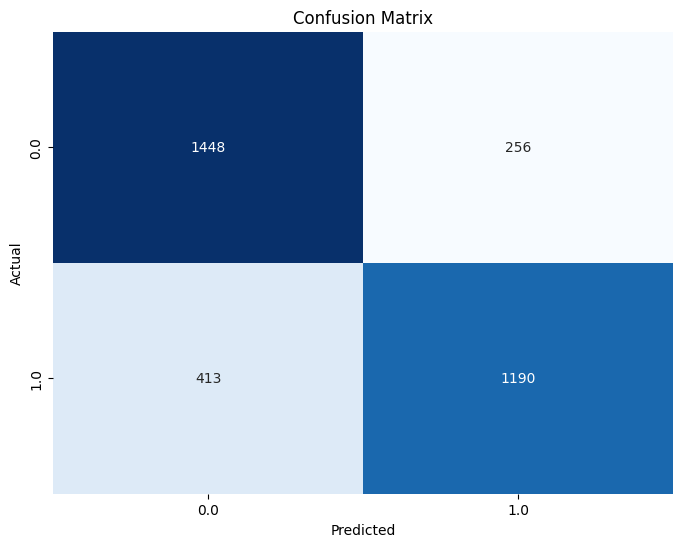

Test accuracy =   0.7977018445721198


In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Create MulticlassMetrics object
 #Convert predictions and labels to RDD for MulticlassMetrics
prediction_and_labels = predictionsovr.select("prediction", "label") \
    .withColumnRenamed("indexedLabel", "label") \
    .toPandas()  # Convert to Pandas DataFrame for easier manipulation
# Create a confusion matrix using Pandas
confusion_matrix = pd.crosstab(prediction_and_labels['label'], prediction_and_labels['prediction'], rownames=['Actual'], colnames=['Predicted'])

# Plot the confusion matrix using Seaborn and Matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

evaluator = MulticlassClassificationEvaluator(\
labelCol="label", predictionCol="prediction",\
metricName="accuracy")
accuracy = evaluator.evaluate(predictionsovr)
print("Test accuracy =  " , accuracy)

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
train, test = dfSelected.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)

#predictions.select("label","prediction").show(10)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)
print("Total Actual Positive",predictions.select("label").where('label == 1.0').count())
print("Total Actual Negative",predictions.select("label").where('label == 0.0').count())
pr = predictions.toPandas()
TruePositive =0
FalsePositive=0
TrueNegative=0
FalseNegative=0
Postive=1.0
Negative=0.0
pos=0
Neg=0

print("Total",len(pr["label"]))
for lbl in range(len(pr["label"])):
  if  pr["prediction"][lbl]==Postive:
    pos+=1
    if pr["prediction"][lbl]==pr["label"][lbl]:
      TruePositive+=1
    else:
      FalsePositive+=1
  if  pr["prediction"][lbl]==Negative:
    Neg+=1
    if pr["prediction"][lbl]==pr["label"][lbl]:
      TrueNegative+=1
    else:
      FalseNegative+=1
print("Total Positive & Negative in Prediction. Pos: ",pos,",Neg",Neg)
print("TruePostive",TruePositive,"FalsePostive",FalsePositive)
print("TrueNegative",TrueNegative,"FalseNegative",FalseNegative)

Training Dataset Count: 7855
Test Dataset Count: 3307
+---+----------+-----+--------------+----------+--------------------+
|age|       job|label| rawPrediction|prediction|         probability|
+---+----------+-----+--------------+----------+--------------------+
| 33|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 49|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 52|management|  0.0|[520.0,1931.0]|       1.0|[0.21215830273357...|
| 53|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 58|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 32|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 57|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 52|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 46|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 31|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
+---+----------+-----+--------------

In [ ]:
#predictions.show(10)
#print(dtModel.toDebugString)
#Evaluate our Decision Tree model.

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()

print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7808118726917547


In [ ]:
#RandomForest
from pyspark.ml.classification import RandomForestClassifier
#rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rf = RandomForestClassifier(featuresCol='features', labelCol='label', maxDepth = 4,numTrees=20)
train, test = dfSelected.randomSplit([0.7, 0.3], seed = 2018)
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
pr = predictions.toPandas()
print("Total Actual Positive",predictions.select("label").where('label == 1.0').count())
print("Total Actual Negative",predictions.select("label").where('label == 0.0').count())

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
TruePositive =0
FalsePositive=0
TrueNegative=0
FalseNegative=0
Postive=1.0
Negative=0.0
pos=0
Neg=0
print("Total",len(pr["label"]))
for lbl in range(len(pr["label"])):
  if  pr["prediction"][lbl]==Postive:
    pos+=1
    if pr["prediction"][lbl]==pr["label"][lbl]:
      TruePositive+=1
    else:
      FalsePositive+=1
  if  pr["prediction"][lbl]==Negative:
    Neg+=1
    if pr["prediction"][lbl]==pr["label"][lbl]:
      TrueNegative+=1
    else:
      FalseNegative+=1
print("Total positive & Negative in Predictions, Pos",pos,"Neg",Neg)
print("TruePostive",TruePositive,"FalsePostive",FalsePositive)
print("TrueNegative",TrueNegative,"FalseNegative",FalseNegative)

Total Actual Positive 1603
Total Actual Negative 1704
Test Area Under ROC: 0.8682224350469637
Total 3307
Total positive & Negative in Predictions, Pos 1504 Neg 1803
TruePostive 1211 FalsePostive 293
TrueNegative 1411 FalseNegative 392


In [ ]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier

ml = GBTClassifier(maxIter=10, featuresCol='features', labelCol='label',maxDepth = 10)
train, test = dfSelected.randomSplit([0.7, 0.2], seed = 2018)
mlModel = ml.fit(train)
predictions = mlModel.transform(test)

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

# Calculate accuracy and F-1 score
#accuracy_evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
#accuracy = accuracy_evaluator.evaluate(predictions.select('label', 'prediction'))

#f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
#f1_score = f1_score_evaluator.evaluate(predictions.select('label', 'prediction'))
#print(accuracy, f1_score)

Test Area Under ROC: 0.869695789478623


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
gbt = GBTClassifier(maxIter=10)
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.8989346833243608

In [ ]:
predictions.select('label', 'prediction').show(13)

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 13 rows



In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import GBTClassifier, OneVsRest
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
path="/content/iris.csv"
# Start Spark session
spark = SparkSession.builder.appName("GBTClassifier-Multiclass").getOrCreate()

# Load dataset (replace with your path)
iris = spark.read.csv(path, header=True, inferSchema=True)
# Prepare features
feature_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
iris = assembler.transform(iris)

# Index labels
indexer = StringIndexer(inputCol="species", outputCol="label")
iris = indexer.fit(iris).transform(iris)

# Train-test split
train, test = iris.randomSplit([0.8, 0.2], seed=42)

# Initialize GBTClassifier
gbt = GBTClassifier(maxIter=20, maxDepth=3, stepSize=0.1)

# Wrap in OneVsRest for multiclass
ovr = OneVsRest(classifier=gbt)

# Train
model = ovr.fit(train)

# Predict
predictions = model.transform(test)

# Evaluate
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy:.4f}")

spark.stop()

Test Accuracy: 0.9583
